In [43]:
# Setup
from __future__ import division, print_function, unicode_literals

# Imports
import numpy as np
import numpy.random as rnd
import os

# To make make consistent across code blocks
rnd.seed(42)

# Ploting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Saving the functions
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [52]:
#Ploting grayscale and RGB images
def plot_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [53]:
import tensorflow as tf

In [54]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def preprocessing(height, width, channels, path):
    train = unpickle("images/cifar-100-python/"+path)
    
    count = 0
    for i in range(len(train[b'data'])):
         if train[b'coarse_labels'][i]==5 or train[b'coarse_labels'][i]==6:
            count += 1
    
    data = np.zeros((count, width, height, channels))
    labels = np.zeros((count, 2))
   
    count = 0;
    for i in range(50000):
        if train[b'coarse_labels'][i]==5 or train[b'coarse_labels'][i]==6:
            for k in range(channels):
                for j in range(width):
                    for l in range(height):
                        data[count][j][l][k] = train[b'data'][i][int(l + j*32 + k*32*32)] / 255
            labels[count][0] = train[b'coarse_labels'][i]
            labels[count][1] = train[b'fine_labels'][i]
            
            count += 1
    return data, labels

In [ ]:
height = 32
width = 32
channels = 3

data, labels = preprocessing(height, width, channels, "train");

print(labels)
plot_image(data[0])

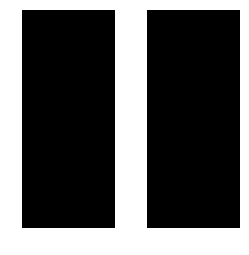

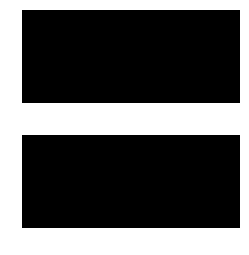

In [48]:
fmap = np.zeros(shape=(7,7,1,2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
fmap[:, :, 0, 0]
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

In [49]:
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

graph = tf.Graph()
with graph.as_default():
    with tf.name_scope("inputs"):
        X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
        X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
        y = tf.placeholder(tf.int32, shape=[None], name='y')
    
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize, strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu, name="conv1")
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize, strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu, name="conv2")
    
    with tf.name_scope("pool3"):
        pool3 = tf.nn.max_pool(conv2,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
        pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])
        
    with tf.name_scope("fc1"):
        fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    
    with tf.name_scope("output"):
        logits = tf.layers.dense(fc1, n_outputs, name="output")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")
        
    with tf.name_scope("train"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
        loss = tf.reduce_mean(xentropy)
        optimizer = tf.train.AdamOptimizer();
        training_op = optimizer.minimize(loss);
        
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    with tf.name_scope("init_and_save"):
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

In [51]:
n_epochs = 10
batch_size = 1

with tf.Session(graph=graph) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(data) // batch_size):
            X_batch = data
            y_batch = labels[0]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train Accuracy:", acc_train, "Test Accuracy: ", acc_test)
        
        save_path = saver.save(sess, "./cifar")

ValueError: Cannot feed value of shape (5000, 32, 32, 3) for Tensor 'inputs/X:0', which has shape '(?, 1024)'